In [6]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from datetime import datetime

import os
import sys
cur_dir = os.path.dirname(os.path.abspath("__file__"))  # Gets the current notebook directory
src_dir = os.path.join(cur_dir, '../')  # Constructs the path to the 'src' directory
# Add the 'src' directory to sys.path
if src_dir not in sys.path:
    sys.path.append(src_dir)

from src.constant import *
from tqdm.notebook import tqdm

from src.MyDataset import MyDataset, save_dataset, load_dataset
from src.TFT_Flowmatching import TemporalFusionTransformerDiffusion

from src.VQVAE import VQVAE
from typing import Optional
import pickle

import torch.utils
import torch.utils.data

## Optional: direct load data from Cache

In [ ]:
# train = load_dataset('../data/.cache/train.pkl')
# test = load_dataset('../data/.cache/test.pkl')
# stats_dict = pickle.load(open('../data/.cache/stats_dict.pkl', 'rb'))
# feature_dim = stats_dict['feature_dim']
# features = stats_dict['features']

lookback = 30
future_steps = 40
resample = False
dir = '../data/Phase3/Modified/'
ds = MyDataset(lookback=lookback)
train_batch_size = 16
test_batch_size = 64

In [ ]:


def process_data(df_dir : str, target_freq : int = 10):
    states = ['At Station', 'Error', 'Wait', 'Cross', 'Approach Sidewalk',
       'Approach Target Station', 'Move Along Sidewalk']

    states_ohe = pd.get_dummies(df['state'], prefix='state')
    cur_states = df['state'].unique()
    for state in states:
        if state not in cur_states:
            states_ohe['state_'+state] = 0

    df = pd.concat([df, states_ohe], axis=1)
    df.drop(columns=['state'], inplace=True)
    
    df.dropna(inplace=True, how='any')
    if resample:
        f_per_sec = df.groupby('TimestampID').count().mean().mean()
        if f_per_sec < target_freq:
            raise ValueError('The frequency of the data is lower than the target frequency')
        elif int(f_per_sec) == target_freq:
            pass
        else:
            resample_ratio = int(f_per_sec/target_freq)
            df = df.iloc[::resample_ratio, :]
    # # for origin
    for drop_column in ['Confidence', 'Timestamp', 'TimestampID', 
                          'DatapointID', 'PID', 'SCN', 'U_X', 'U_Y', 'U_Z', 
                          'AGV_Z', 'User_Z', 'GazeOrigin_Z', 'User_Pitch', 'User_Yaw', 'User_Roll', 
                          'EyeTarget', 
                          'start_station_X', 'start_station_Y', 'end_station_X', 'end_station_Y',
                          'distance_from_start_station_X',
                            'distance_from_start_station_Y', 'distance_from_end_station_X',
                            'distance_from_end_station_Y', 'facing_start_station',
                            'facing_end_station', 
                            'rolling_avg', 
                            'User', 'Type', 
                            'possible_interaction'
                          ]:
        df = df.drop(columns=[drop_column], errors='ignore')

    target_columns = ['User_X', 'User_Y']
    # Reorder columns
    new_columns = target_columns + [col for col in df.columns if col not in target_columns]
    df = df[new_columns]
    
    # keep numeric columns
    df = df.apply(pd.to_numeric, errors='ignore')

    return df

for file in os.listdir(dir):
    if file.endswith('.pkl'):
        df = process_data(dir+file)
        ds.read_data(df, agv_col_name="scenario")


### Optional: shuffle the dataset

In [3]:
# import random
# random.shuffle(ds.dataset)

In [19]:
stats_dict = {'mean': 0, 'std': 0, 'min': 0, 'max': 0}
stats_dict = ds.normalize_dataset()
ds.generate_data(future_steps=future_steps)

train:torch.utils.data.DataLoader
test:torch.utils.data.DataLoader

train, test = ds.split_data(frac=0.9, shuffle=True, train_batch_size=train_batch_size, test_batch_size=test_batch_size)

feature_dim = ds.feature_dim
stats_dict['feature_dim'] = feature_dim
stats_dict['features'] = ds.dataset[0].columns
columns = [_ for _ in ds.dataset[0].columns if _ not in ['AGV_name']]
print(f"columns : {df.columns} \nfeature_dim : {feature_dim}")

columns : Index(['User_X', 'User_Y', 'AGV_distance_X', 'AGV_distance_Y', 'AGV_speed_X',
       'AGV_speed_Y', 'AGV_speed', 'User_speed_X', 'User_speed_Y',
       'User_speed', 'User_velocity_X', 'User_velocity_Y', 'Wait_time',
       'intent_to_cross', 'Gazing_station', 'facing_along_sidewalk',
       'facing_to_road', 'On_sidewalks', 'On_road', 'closest_station',
       'distance_to_closest_station', 'distance_to_closest_station_X',
       'distance_to_closest_station_Y', 'looking_at_AGV', 'GazeDirection_X',
       'GazeDirection_Y', 'GazeDirection_Z', 'AGV_X', 'AGV_Y',
       'looking_at_closest_station', 'data_active', 'scenario',
       'state_Approach Sidewalk', 'state_Approach Target Station',
       'state_At Station', 'state_Cross', 'state_Error',
       'state_Move Along Sidewalk', 'state_Wait'],
      dtype='object') 
feature_dim : 38


['User_X', 'User_Y', 'AGV_distance_X', 'AGV_distance_Y', 'AGV_speed_X',
       'AGV_speed_Y', 'AGV_speed', 'User_speed_X', 'User_speed_Y',
       'User_speed', 'User_velocity_X', 'User_velocity_Y', 'Wait_time',
       'intent_to_cross', 'Gazing_station', 'possible_interaction',
       'facing_along_sidewalk', 'facing_to_road', 'On_sidewalks', 'On_road',
       'closest_station', 'distance_to_closest_station',
       'distance_to_closest_station_X', 'distance_to_closest_station_Y',
       'looking_at_AGV', 'GazeDirection_X', 'GazeDirection_Y',
       'GazeDirection_Z', 'AGV_X', 'AGV_Y', 'looking_at_closest_station']

In [5]:
for i, (X, y) in enumerate(train):
    print(X.shape, y.shape)
    break

print(len(train) * train_batch_size, len(test) * test_batch_size)

# save it to cache to speed up
# save_dataset(train, type='train', file_path='../data/.cache/train.pkl')
# save_dataset(test, type='test', file_path='../data/.cache/test.pkl')
# pickle.dump(stats_dict, open('../data/.cache/stats_dict.pkl', 'wb'))


torch.Size([16, 30, 38]) torch.Size([16, 40, 38])
317840 35328


In [151]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional
from src.VQVAE import VQVAE

###############################################
# Original Blocks (with minor efficiency tweaks)
###############################################

class GatedResidualNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=3, dropout_rate=0.1):
        super(GatedResidualNetwork, self).__init__()
        self.layers = nn.ModuleList(
            [nn.Linear(input_size if i == 0 else hidden_size, hidden_size) for i in range(num_layers)]
        )
        self.norms = nn.ModuleList([nn.LayerNorm(hidden_size) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.fc3 = nn.Linear(input_size, output_size)
        self.gate = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x_input = x
        for layer, norm in zip(self.layers, self.norms):
            x = F.relu(layer(x))
            x = self.dropout(x)
            x = norm(x)
        gate = torch.sigmoid(self.gate(x))
        x2 = self.fc2(x)
        return self.fc3(x_input) + gate * x2

class TransformerBlock(nn.Module):
    def __init__(self, hidden_size, num_heads, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(hidden_size, num_heads, dropout=dropout_rate)
        self.norm1 = nn.LayerNorm(hidden_size)
        self.norm2 = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.feed_forward = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 4),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size * 4, hidden_size)
        )

    def forward(self, x, mask: Optional[torch.Tensor] = None):
        # x: (seq_len, batch, hidden_size)
        x2 = x
        x = self.norm1(x)
        x, _ = self.attention(x, x, x, key_padding_mask=mask)
        x = x + x2
        x2 = x
        x = self.norm2(x)
        x = self.feed_forward(x)
        x = x + x2
        return x

###############################################
# Diffusion–based Decoder
###############################################

class DiffusionDecoder(nn.Module):
    """
    A diffusion–based decoder that iteratively denoises an initial noise sample
    to produce the final output (e.g. action predictions). Conditioning comes from
    an encoded summary (e.g. the last token from the transformer encoder).
    """
    def __init__(self, action_dim, conditioning_dim, num_diffusion_steps=20, num_action_steps=20,
                 num_heads=4, hidden_dim=128):
        """
        Args:
            action_dim (int): Dimensionality of the output (e.g. number of action dimensions).
            conditioning_dim (int): Dimensionality of the conditioning feature.
            num_diffusion_steps (int): How many denoising steps to perform.
            num_action_steps (int): Length of the output sequence.
            num_heads (int): Number of attention heads in the cross-attention.
            hidden_dim (int): Hidden dimension for the denoiser.
        """
        super(DiffusionDecoder, self).__init__()
        self.action_dim = action_dim
        self.num_diffusion_steps = num_diffusion_steps
        self.num_action_steps = num_action_steps
        self.hidden_dim = hidden_dim
        
        # Embed a scalar timestep into a hidden vector.
        self.time_embed = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        # Project the noisy action sample to the hidden dimension.
        self.query_proj = nn.Linear(action_dim, hidden_dim)
        # Cross–attention: query from current noisy actions, keys/values from conditioning.
        self.cross_attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, dropout=0.1)
        # Project back to action dimension.
        self.output_proj = nn.Linear(hidden_dim, action_dim)
        # Optional feed-forward refinement.
        self.ffn = nn.Sequential(
            nn.Linear(action_dim, action_dim * 4),
            nn.ReLU(),
            nn.Linear(action_dim * 4, action_dim)
        )
        self.norm = nn.LayerNorm(action_dim)

    def denoise_step(self, conditioning, x_t, timestep):
        """
        One denoising step.
        
        Args:
            conditioning: Tensor of shape (batch, cond_len, conditioning_dim).
                        (Ideally, conditioning_dim == hidden_dim.)
            x_t: Tensor of shape (batch, num_action_steps, action_dim) -- current noisy sample.
            timestep: Tensor of shape (batch,) with the current diffusion timestep.
            
        Returns:
            v_t: Denoising estimate (same shape as x_t).
        """
        batch_size = x_t.size(0)
        
        # Embed the scalar timestep.
        t = timestep.view(batch_size, 1)  # (batch, 1)
        t_emb = self.time_embed(t)        # (batch, hidden_dim)
        t_emb = t_emb.unsqueeze(1)         # (batch, 1, hidden_dim)
        
        # Project the noisy sample and add the time embedding.
        query = self.query_proj(x_t) + t_emb  # (batch, num_action_steps, hidden_dim)
        
        # Prepare for multihead attention: (num_action_steps, batch, hidden_dim).
        query = query.transpose(0, 1)
        key   = conditioning.transpose(0, 1)  # conditioning: (cond_len, batch, hidden_dim)
        value = conditioning.transpose(0, 1)
        
        attn_output, _ = self.cross_attn(query, key, value)
        attn_output = attn_output.transpose(0, 1)  # (batch, num_action_steps, hidden_dim)
        
        # Project back to action space.
        v_t = self.output_proj(attn_output)  # Use only the last timestep.
        # Add residual connection and refine.
        v_t = self.norm(x_t + v_t)
        v_t = v_t + self.ffn(v_t)
        return v_t
    
    def predict_v(self, conditioning, x_t, timestep):
        """
        A thin wrapper that predicts v_theta for a given x_t and timestep.
        """
        return self.denoise_step(conditioning, x_t, timestep)

    def forward(self, conditioning, noise=None):
        """
        Run the diffusion process to generate the final output.
        
        Args:
            conditioning: (batch, cond_len, conditioning_dim)
            noise: Optional initial noise of shape (batch, num_action_steps, action_dim).
                   If None, standard Gaussian noise is used.
                   
        Returns:
            x_t: The denoised output (batch, num_action_steps, action_dim)
        """
        batch_size = conditioning.size(0)
        device = conditioning.device
        
        if noise is None:
            noise = torch.randn(batch_size, self.num_action_steps, self.action_dim, device=device)
        
        # Here we use a simple Euler integration schedule:
        dt = -1.0 / self.num_diffusion_steps  # dt < 0 so time goes from 1.0 -> 0.
        time = torch.full((batch_size,), 1.0, device=device, dtype=torch.float32)
        
        x_t = noise
        for _ in range(self.num_diffusion_steps):
            v_t = self.denoise_step(conditioning, x_t, time)
            x_t = x_t + dt * v_t
            time = time + dt
        return x_t

###############################################
# Modified Temporal Fusion Transformer with Diffusion Decoder
###############################################

class TemporalFusionTransformerDiffusion(nn.Module):
    def __init__(self, num_features, num_hidden, num_outputs, num_steps,
                 num_attention_heads=8, diffusion_steps=10, vqvae: VQVAE = None):
        """
        Args:
            num_features (int): Number of input features.
            num_hidden (int): Hidden dimension size.
            num_outputs (int): Dimensionality of each output (e.g. action dimension).
            num_steps (int): Desired output sequence length (e.g. number of action steps).
            num_attention_heads (int): Number of heads for the transformer blocks.
            diffusion_steps (int): Number of diffusion (denoising) steps.
        """
        super(TemporalFusionTransformerDiffusion, self).__init__()
        if vqvae is None:
            self.vqvae = VQVAE(input_dim=feature_dim, hidden_dim=512, num_embeddings=128, embedding_dim=128, commitment_cost=0.25)
        else:
            self.vqvae = vqvae
        num_features = num_features + self.vqvae.encoder.fc2.out_features
        self.encoder_grn = GatedResidualNetwork(num_features, num_hidden, num_hidden)
        self.transformer_block = TransformerBlock(num_hidden, num_heads=num_attention_heads, dropout_rate=0.1)
        self.transformer_block2 = TransformerBlock(num_hidden, num_heads=num_attention_heads, dropout_rate=0.1)
        
        # To condition the diffusion process we project the transformer output.
        self.condition_proj = nn.Linear(num_hidden, num_hidden)
        # Diffusion decoder: we set action_dim=num_outputs and produce a sequence of length num_steps.
        self.diffusion_decoder = DiffusionDecoder(
            action_dim=num_outputs,
            conditioning_dim=num_hidden,
            num_diffusion_steps=diffusion_steps,
            num_action_steps=num_steps,
            num_heads=4,  # you can adjust as needed
            hidden_dim=num_hidden
        )

        self.num_steps = num_steps
        self.num_outputs = num_outputs

    def forward(self, x, mask: Optional[torch.Tensor] = None, y_batch=None, influence=False):
        """
        Args:
            x: Input tensor of shape (batch, seq_len, num_features).
            mask: Optional attention mask for the transformer blocks.
            
        Returns:
            actions: Tensor of shape (batch, num_steps, num_outputs)
        """
        # If given a 2D input, add a batch dimension.
        if len(x.shape) == 2:
            x = x.unsqueeze(0)
        batch_size, seq_len, _ = x.shape

        # VQ-VAE
        x_recon, vq_loss, perplexity, embedding = self.vqvae(x)
        x = torch.cat((x, embedding), dim=-1)
        
        # Encoder GRN.
        x = self.encoder_grn(x)  # (batch, seq_len, num_hidden)
        
        # Transformer expects (seq_len, batch, hidden_size).
        x = x.permute(1, 0, 2)
        x = self.transformer_block(x, mask=mask)
        x = self.transformer_block2(x, mask=mask)
        x = x.permute(1, 0, 2)  # back to (batch, seq_len, num_hidden)
        
        # Use a summary of the encoder output as conditioning.
        # Here we use the last time–step (you might also try an average or more complex pooling).
        conditioning = self.condition_proj(x[:, -1:, :])  # (batch, 1, num_hidden)
        # conditioning = self.condition_proj(x[:, :, :])  # (batch, 1, num_hidden)


        # flow matching during training
        self.device = next(self.parameters()).device
        flow_loss = torch.tensor(0.0, device=self.device)
        # if self.training and y_batch is not None:
        #     # Sample a random time t in [0,1] for flow matching.
        #     t_flow = torch.rand(batch_size, 1, 1, device=self.device)  # shape: (batch, 1, 1)
        #     # Sample noise for the diffusion process.
        #     # (Assuming your diffusion decoder predicts sequences of length equal to future_steps and action dim of 2.)
        #     noise_flow = torch.randn(batch_size, future_steps, self.num_outputs, device=self.device)
        #     # Compute the intermediate sample and target flow using the helper function.
        #     # (Assuming y_batch[:, :future_steps, :2] is your ground truth target.)
        #     x_t_flow, v_target = compute_flow_target(noise_flow, y_batch[:, :future_steps, :self.num_outputs], t_flow)
            
        #     # Predict the velocity (v_pred) using the diffusion decoder.
        #     # Adjust t_flow shape as needed (here squeezed to shape (batch,)).
        #     v_pred = self.diffusion_decoder.predict_v(conditioning, x_t_flow, t_flow.squeeze(-1).squeeze(-1))
            
        #     # Compute the flow matching loss (MSE between predicted flow and target flow).
        #     flow_loss = F.mse_loss(v_pred, v_target)

        #     User_trajectory = self.diffusion_decoder(conditioning)
        #     return User_trajectory, vq_loss, perplexity, flow_loss

        # Run the diffusion process to generate outputs.
        User_trajectory = self.diffusion_decoder(conditioning)
        if influence:
            return User_trajectory
        else:
            return User_trajectory, vq_loss, perplexity, flow_loss


    def influence(self, x):
        User_trajectory = self.forward(x, influence=True)
        return User_trajectory

def compute_flow_target(noise, target, t, schedule_fn=lambda t: t):
    """
    Computes an intermediate sample x_t and its target flow v_target.
    
    Args:
        noise: Tensor of shape (batch, num_action_steps, action_dim)
        target: Ground truth output tensor of shape (batch, num_action_steps, action_dim)
        t: Tensor of shape (batch, 1, 1) with time values in [0,1]
        schedule_fn: A function φ(t) that maps time to interpolation weight.
                     For a linear schedule, schedule_fn(t)=t.
                     
    Returns:
        x_t: The intermediate sample at time t.
        v_target: The target flow, i.e., d x_t / dt.
    """
    # Compute interpolation weight and its derivative.
    phi = schedule_fn(t)              # shape: (batch, 1, 1)
    # For linear schedule, dphi/dt = 1. Otherwise, adjust accordingly.
    dphi_dt = torch.ones_like(phi)    # Modify if using a non-linear schedule.
    
    # Interpolate: x(t) = (1 - φ(t)) * noise + φ(t) * target
    x_t = (1 - phi) * noise + phi * target
    
    # The target flow is: v_target = dφ/dt * (target - noise)
    v_target = dphi_dt * (target - noise)
    
    return x_t, v_target


In [152]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")


vqvae = VQVAE(input_dim=feature_dim, hidden_dim=512, num_embeddings=128, embedding_dim=128, commitment_cost=0.25)

model = TemporalFusionTransformerDiffusion(num_features=feature_dim, num_hidden=128, num_outputs=2, num_steps=future_steps, diffusion_steps=10, vqvae=vqvae)
optimizer = optim.AdamW(model.parameters(), lr=2e-4)
model.to(device)

Using cuda


TemporalFusionTransformerDiffusion(
  (vqvae): VQVAE(
    (encoder): VQVAEEncoder(
      (fc1): Linear(in_features=38, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=128, bias=True)
    )
    (quantizer): VectorQuantizer(
      (embedding): Embedding(128, 128)
    )
    (decoder): VQVAEDecoder(
      (fc1): Linear(in_features=128, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=38, bias=True)
    )
  )
  (encoder_grn): GatedResidualNetwork(
    (layers): ModuleList(
      (0): Linear(in_features=166, out_features=128, bias=True)
      (1-2): 2 x Linear(in_features=128, out_features=128, bias=True)
    )
    (norms): ModuleList(
      (0-2): 3 x LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (fc3): Linear(in_features=166, out_features=128, bias=True)
    (gate): Linear(in_features=128, out_features=12

### Customized Loss Function

In [153]:
class DecayLoss(nn.Module):
    def __init__(self, num_steps, baseline_loss_fn=nn.L1Loss()):
        super(DecayLoss, self).__init__()
        # Weight decreases as we move further into the future
        self.weights = torch.linspace(1.0, 1.0, num_steps)
        self.baseline_loss_fn = baseline_loss_fn
        

    def forward(self, predictions, targets):
        loss = 0
        for i in range(predictions.shape[1]):
            loss += self.weights[i] * self.baseline_loss_fn(predictions[:, i], targets[:, i])
        return loss
    
    
baseline_loss_fn = nn.L1Loss() #nn.MSELoss()
loss_fn = DecayLoss(future_steps, baseline_loss_fn=baseline_loss_fn)

### Trainer with early stop

In [154]:
# Parameters
n_epochs = 10
eval_step = 100
save_every = 10000
patience = 8  # Number of evaluations to wait for improvement
cooldown = 4  # Evaluations to wait after an improvement before counting non-improvements
smooth_factor = 0.6  # Smoothing factor for moving average
lambda_flow = 1e-3  # Weight for flow matching loss

# Setup
train_all = len(train)
model_name = "TFT_Flowmatching"
from collections import defaultdict
loss_all = defaultdict(list)
best_test_rmse = float('inf')
early_stopping_counter = 0
cooldown_counter = cooldown

now = datetime.now()
folder_name = now.strftime("%b%d_%H-%M-%S")
print(f"Saving model at ../model/{model_name}/{folder_name}")

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train) * n_epochs, eta_min=1e-6)

# Initialize moving average
moving_avg_test_rmse = None

# Training loop
for epoch in range(n_epochs):
    model.train()
    for step, (X_batch, y_batch) in tqdm(enumerate(train), total=train_all):
        X_batch = X_batch.float().to(device)
        y_batch = y_batch.float().to(device)
        
        current_pos_input = X_batch[:, -1, :2].clone().unsqueeze(1).repeat(1, lookback, 1)
        current_pos_output = X_batch[:, -1, :2].clone().unsqueeze(1).repeat(1, future_steps, 1)
        X_batch[:, :, :2] = X_batch[:, :, :2] - current_pos_input
        y_batch[:, :, :2] = y_batch[:, :, :2] - current_pos_output
        optimizer.zero_grad()
        
        y_pred, vq_loss, perplexity, flow_loss = model(X_batch, y_batch=y_batch)
        loss = loss_fn(y_pred[:, :future_steps, :2], y_batch[:, :future_steps, :2])
        loss_all['pred_f1_loss'].append(vq_loss.item())
        loss_all['vq_loss'].append(vq_loss.item() * 10)
        # add vq_loss
        loss += 10 * vq_loss
        # add flow_loss
        loss += lambda_flow * flow_loss
        loss_all['flow_loss'].append(flow_loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        # Save model
        if (epoch * train_all + step + 1) % save_every == 0:
            os.makedirs(f'../model/{model_name}/{folder_name}', exist_ok=True)
            save_path = f"../model/{model_name}/{folder_name}/model_{epoch * train_all + step + 1}.pt"
            torch.save(model.state_dict(), save_path)
            print(f"Model saved at {save_path}")

        # Validation and early stopping
        if (epoch * train_all + step + 1) % eval_step == 0:
            model.eval()
            test_rmse_all = []
            with torch.no_grad():
                for X_test_batch, y_test_batch in test:
                    X_test_batch = X_test_batch.float().to(device)
                    y_test_batch = y_test_batch.float().to(device)
                    
                    current_pos_input = X_test_batch[:, -1, :2].clone().unsqueeze(1).repeat(1, lookback, 1)
                    current_pos_output = X_test_batch[:, -1, :2].clone().unsqueeze(1).repeat(1, future_steps, 1)
                    X_test_batch[:, :, :2] = X_test_batch[:, :, :2] - current_pos_input
                    y_test_batch[:, :, :2] = y_test_batch[:, :, :2] - current_pos_output
                    
                    y_pred_test = model(X_test_batch, influence=True)
                    loss_test = loss_fn(y_pred_test[:, :future_steps, :2], y_test_batch[:, :future_steps, :2])
                    test_rmse = torch.sqrt(loss_test)
                    if not torch.isnan(test_rmse):
                        test_rmse_all.append(test_rmse.item())
            
            current_rmse = sum(test_rmse_all) / len(test_rmse_all)
            if moving_avg_test_rmse is None:
                moving_avg_test_rmse = current_rmse
            else:
                moving_avg_test_rmse = smooth_factor * current_rmse + (1 - smooth_factor) * moving_avg_test_rmse

            print(f"Steps {epoch * train_all + step + 1}: test RMSE {current_rmse:.4f}, moving average RMSE {moving_avg_test_rmse:.4f}")

            # Check if the moving average RMSE is better; if not, increment counter
            if moving_avg_test_rmse < best_test_rmse:
                best_test_rmse = moving_avg_test_rmse
                early_stopping_counter = 0  # Reset counter
                cooldown_counter = cooldown  # Reset cooldown
                # Optionally save the best model
                os.makedirs(f'../model/{model_name}/{folder_name}', exist_ok=True)
                best_model_path = f"../model/{model_name}/{folder_name}/best_model.pt"
                torch.save(model.state_dict(), best_model_path)
            else:
                if cooldown_counter > 0:
                    cooldown_counter -= 1
                else:
                    early_stopping_counter += 1

            if early_stopping_counter >= patience:
                print(f"Stopping early at epoch {epoch+1}, step {step+1}")
                break

            model.train()
        
    if early_stopping_counter >= patience:
        break

print("Training complete.")

Saving model at ../model/TFT_Flowmatching/Feb14_11-56-33


  0%|          | 0/19865 [00:00<?, ?it/s]

Steps 100: test RMSE 5.2520, moving average RMSE 5.2520
Steps 200: test RMSE 4.8567, moving average RMSE 5.0148
Steps 300: test RMSE 4.8837, moving average RMSE 4.9362
Steps 400: test RMSE 4.9110, moving average RMSE 4.9210
Steps 500: test RMSE 4.8676, moving average RMSE 4.8890
Steps 600: test RMSE 4.9111, moving average RMSE 4.9023


KeyboardInterrupt: 

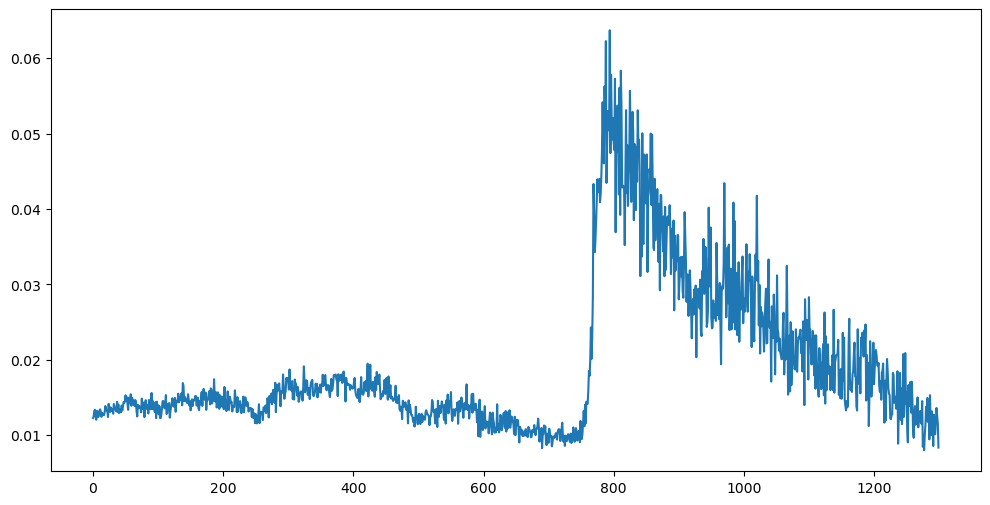

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(loss_all['pred_f1_loss'], label='pred_f1_loss')

In [ ]:
validation_step = future_steps

predictions = []
truths = []

with torch.no_grad():
    model.eval()
    all_test = len(test)
    test_rmse_all = []
    for X_test_batch, y_test_batch in tqdm(test):
        X_test_batch = X_test_batch.float().to(device)
        y_test_batch = y_test_batch.float().to(device)
        
        current_pos_input = X_test_batch[:, -1, :2].clone().unsqueeze(1).repeat(1, lookback, 1)
        current_pos_output = X_test_batch[:, -1, :2].clone().unsqueeze(1).repeat(1, future_steps, 1)
        X_test_batch[:, :, :2] = X_test_batch[:, :, :2] - current_pos_input
        y_test_batch[:, :, :2] = y_test_batch[:, :, :2] - current_pos_output
        
        y_pred = model(X_test_batch, influence=True)
        predictions.append(y_pred[:, :validation_step, :2] + current_pos_output)
        truths.append(y_test_batch[:, :validation_step, :2] + current_pos_output)
        
predictions = torch.cat(predictions, dim=0)
truths = torch.cat(truths, dim=0)

  0%|          | 0/552 [00:00<?, ?it/s]

In [143]:
# reverse normalization
normalize_dict = stats_dict

for idx, key_ in enumerate(["User_X", "User_Y"]):
    predictions[:, :, idx] = predictions[:, :, idx] * (normalize_dict['max'][key_] - normalize_dict['min'][key_]) + normalize_dict['min'][key_]
    predictions[:, :, idx] = predictions[:, :, idx] * normalize_dict['std'][key_] + normalize_dict['mean'][key_]
    truths[:, :, idx] = truths[:, :, idx] * (normalize_dict['max'][key_] - normalize_dict['min'][key_]) + normalize_dict['min'][key_]
    truths[:, :, idx] = truths[:, :, idx] * normalize_dict['std'][key_] + normalize_dict['mean'][key_]

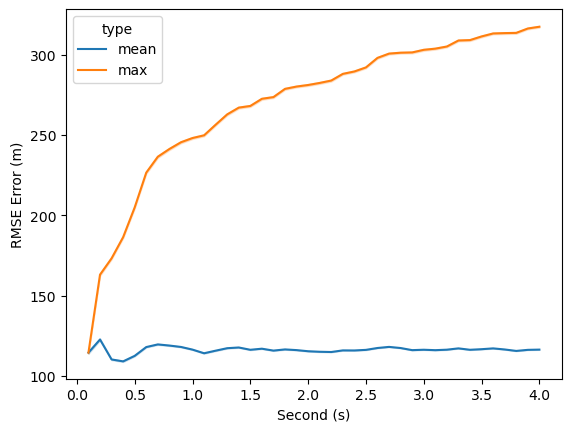

In [ ]:
criterion = nn.MSELoss(reduction="none")

steps = []
loss = []
max_loss = []
for step in range(1, future_steps+1):
    raw_rmse_loss = criterion(predictions[:, :step, :], truths[:, :step, :])
    raw_rmse_loss = torch.sqrt(torch.sum(raw_rmse_loss, dim=-1))
    mean_rmse_loss = raw_rmse_loss.mean(dim=-1)
    max_rmse_loss = raw_rmse_loss.max(dim=-1).values
    loss.append(mean_rmse_loss)
    max_loss.append(max_rmse_loss)
    steps.extend([step] * len(mean_rmse_loss))
    
max_loss = torch.cat(max_loss).cpu().numpy()
loss = torch.cat(loss).cpu().numpy()

df = pd.DataFrame({'Second (s)': steps, 'loss': loss})
df1 = pd.DataFrame({'Second (s)': steps, 'loss': max_loss})
df['type'] = 'mean'
df1['type'] = 'max'
df = pd.concat([df, df1])


df['RMSE Error (m)'] = df['loss'] / 100 # to meters
df['Second (s)'] = df['Second (s)'] / 10 # to seconds
sns.lineplot(data = df, x='Second (s)', y='RMSE Error (m)', hue='type',) #  errorbar=('sd', 1),
plt.savefig(f'../model/{model_name}/{folder_name}/res.png')
plt.show()

In [145]:
exp_results = df.groupby(by=['Second (s)', 'type']).mean().unstack()['RMSE Error (m)']
exp_results.to_csv(f'../model/{model_name}/{folder_name}/result.csv')
exp_results.tail(10)

type,max,mean
Second (s),,
3.1,303.867920,115.930176
3.2,305.200470,116.229156
3.3,308.950317,117.048706
3.4,309.199341,116.171715
3.5,311.474060,116.533920
3.6,313.335785,117.040726
3.7,313.561401,116.364456
3.8,313.699310,115.458778
3.9,316.425659,116.127029


### Export JIT Model

Integrate partial of data processing into the model

In [ ]:
# # EXPORT_MODEL = True

# # # model.load_state_dict(torch.load("/home/shaoze/Documents/Boeing/Boeing-Trajectory-Prediction/model/Jul09_20-37-37/model_40000.pt"))
# # if EXPORT_MODEL:
# #     model.eval()
# #     model.to('cpu')
# #     script_module = torch.jit.script(model)
# #     os.makedirs(f'../model/exported/', exist_ok=True)
# #     script_module.save("../exported/model_tft_vqvae_cpu.pt")

# stats = {}
# '''
# mean: tensor[]
# '''

# for keys, values in stats_dict.items():
#     stats[keys] = torch.tensor(values.to_list()).view(1,1,-1)
    
# class TFT_EXP(nn.Module):
#     def __init__(self, model:EnhancedTFT, stats:dict):
#         super(TFT_EXP, self).__init__()
#         self.stats = stats
#         self.register_buffer('mean', self.stats['mean'])
#         self.register_buffer('std', self.stats['std'])
#         self.register_buffer('min', self.stats['min'])
#         self.register_buffer('max', self.stats['max'])
#         self.TFT = model
#         self.num_steps = model.num_steps
#         self.num_outputs = model.num_outputs # =2

#     def forward(self, x, mask: Optional[torch.Tensor]=None):
#         single = False
#         if len(x.shape) == 2:
#             x = x.unsqueeze(0)
#             single = True
        
#         # normalize
#         x = (x - self.mean) / self.std
#         x = (x - self.min) / (self.max - self.min)
#         # residual
#         current_pos_input = x[:, -1, :2].clone().unsqueeze(1).repeat(1, x.shape[1], 1)
#         current_pos_output = x[:, -1, :2].clone().unsqueeze(1).repeat(1, self.num_steps, 1)
#         x[:, :, :2] = x[:, :, :2] - current_pos_input
        
#         # pass through TFT
#         outputs, vq_loss, perplexity = self.TFT(x, mask)
#         outputs = outputs.detach()
        
#         # de-residual
#         outputs[:, :, :2] = outputs[:, :, :2] + current_pos_output
        
#         # denormalize
#         outputs = outputs * (self.max[:,:,:self.num_outputs] - self.min[:,:,:self.num_outputs]) + self.min[:,:,:self.num_outputs]
#         outputs = outputs * self.std[:,:,:self.num_outputs] + self.mean[:,:,:self.num_outputs]
        
#         if single:
#             outputs = outputs.squeeze(0)
#         return outputs

# tft_exp = TFT_EXP(model, stats)
# tft_exp.to('cpu')
# tft_exp.eval()
# # script_module = torch.jit.script(tft_exp)
# # os.makedirs(f'../model/exported/', exist_ok=True)
# # script_module.save("../exported/model_tft_vqvae_cpu_preproc.pt")

# # export to onnx

# dummy_input = torch.randn(1, lookback, feature_dim)
# print(f"Input shape: {dummy_input.shape}")

# # Export the wrapped model to ONNX format
# torch.onnx.export(
#     tft_exp,                   # Wrapped model to export
#     dummy_input,                     # Model input
#     "../exported/tft_1111.onnx",              # Output file name
#     export_params=True,              # Store the trained parameter weights inside the model file
#     opset_version=13,                # Set the ONNX opset version (adjust as needed)
#     do_constant_folding=True,        # Whether to execute constant folding for optimization
#     input_names=['input'],           # The model's input names
#     output_names=['output'],         # The model's output names
#     # dynamic_axes={
#     #     'input': {0: 'batch_size'},  # Dynamic batch_size and sequence_length
#     #     'output': {0: 'batch_size'}  # Dynamic batch_size for the output
#     # }
# )
        

In [ ]:
# import onnxruntime as ort
# import numpy as np

# # Path to your ONNX model
# model_path = "../exported/tft_1111.onnx"

# # Create an inference session
# session = ort.InferenceSession(model_path)

# # Get the name of the input node
# input_name = session.get_inputs()[0].name

# for file in os.listdir(dir):
#     if file.endswith('.pkl'):
#         df = process_data(dir+file)
#     break

# df = df[['User_X', 'User_Y', 'AGV_distance_X', 'AGV_distance_Y', 'AGV_speed_X',
#        'AGV_speed_Y', 'AGV_speed', 'User_speed_X', 'User_speed_Y',
#        'User_speed', 'User_velocity_X', 'User_velocity_Y', 'Wait_time',
#        'intent_to_cross', 'Gazing_station', 'possible_interaction',
#        'facing_along_sidewalk', 'facing_to_road', 'On_sidewalks', 'On_road',
#        'closest_station', 'distance_to_closest_station',
#        'distance_to_closest_station_X', 'distance_to_closest_station_Y',
#        'looking_at_AGV', 'GazeDirection_X', 'GazeDirection_Y',
#        'GazeDirection_Z', 'AGV_X', 'AGV_Y',
#        'looking_at_closest_station']]

# start_idx = 100
# input = df.iloc[200:200+lookback].astype(np.float32).values

# # add batch
# input = input[np.newaxis, :, :]
# # Run the model
# output = session.run(None, {input_name: input.astype(np.float32)})[0]

# output



### Save data (for interactive visualization)

In [148]:
# model = torch.jit.load("../exported/model_tft_vqvae_cpu.pt")

# test_ds = MyDataset(lookback=lookback)
# all_ds = ds.dataset
# test_ds.dataset = all_ds[len(all_ds)//10 :] # load the last 10% of the data
# X_list, y_list = test_ds.generate_data(return_list=True, future_steps=future_steps)


In [149]:
# from torch.utils.data import DataLoader, Dataset, TensorDataset

# normalize_dict = stats_dict
# pred_data = []
# truth_data = []
# input_data = []
# model.eval()
# device = 'cpu'
# for i, (X, y) in enumerate(zip(X_list, y_list)):
#     current_pos_input = X[:, -1, :2].clone().unsqueeze(1).repeat(1, lookback, 1)
#     current_pos_output = X[:, -1, :2].clone().unsqueeze(1).repeat(1, future_steps, 1).to(device)
#     X[:, :, :2] = X[:, :, :2] - current_pos_input

#     predictions = model(X.float().to(device))[0][:, :future_steps, :2]
#     predictions = predictions + current_pos_output
#     predictions = predictions.to('cpu')
    
#     truths = y[:, :future_steps, :2]
#     X[:, :, :2] = X[:, :, :2] + current_pos_input
#     model_input = X.float().to(device)[:, :lookback, :2]
#     trajectory_id = i
    
#     # reverse normalization
#     for idx, key_ in enumerate(["User_X", "User_Y"]):
#         predictions[:, :, idx] = predictions[:, :, idx] * (normalize_dict['max'][key_] - normalize_dict['min'][key_]) + normalize_dict['min'][key_]
#         predictions[:, :, idx] = predictions[:, :, idx] * normalize_dict['std'][key_] + normalize_dict['mean'][key_]
#         truths[:, :, idx] = truths[:, :, idx] * (normalize_dict['max'][key_] - normalize_dict['min'][key_]) + normalize_dict['min'][key_]
#         truths[:, :, idx] = truths[:, :, idx] * normalize_dict['std'][key_] + normalize_dict['mean'][key_]
#         model_input[:, :, idx] = model_input[:, :, idx] * (normalize_dict['max'][key_] - normalize_dict['min'][key_]) + normalize_dict['min'][key_]
#         model_input[:, :, idx] = model_input[:, :, idx] * normalize_dict['std'][key_] + normalize_dict['mean'][key_]
    
#     for group_id in range(predictions.shape[0]):
#         for time_step in range(predictions.shape[1]):
#             pred_x, pred_y = predictions[group_id, time_step]
#             pred_data.append([trajectory_id, group_id, time_step, pred_x.item(), pred_y.item()])

#             truth_x, truth_y = truths[group_id, time_step]
#             truth_data.append([trajectory_id, group_id, time_step, truth_x.item(), truth_y.item()])
        
#         for time_step in range(lookback):
#             input_x, input_y = model_input[group_id, time_step]
#             input_data.append([trajectory_id, group_id, time_step, input_x.item(), input_y.item()])
            

# pred_df = pd.DataFrame(pred_data, columns=['trajectory_id', 'Group_ID', 'Time_Step', 'X', 'Y'])
# truth_df = pd.DataFrame(truth_data, columns=['trajectory_id', 'Group_ID', 'Time_Step', 'X', 'Y'])
# input_df = pd.DataFrame(input_data, columns=['trajectory_id', 'Group_ID', 'Time_Step', 'X', 'Y'])


In [150]:
# files_to_remove = [
#     "../data/pred_tra_all.pkl",
#     "../data/truth_tra_all.pkl", 
#     "../data/input_tra_all.pkl"
# ]

# for file_path in files_to_remove:
#     if os.path.exists(file_path):
#         os.remove(file_path)

# truth_df.to_pickle("../data/truth_tra_all.pkl")
# pred_df.to_pickle("../data/pred_tra_all.pkl")
# input_df.to_pickle("../data/input_tra_all.pkl")